In [4]:
'''
This script is used in order to do the necessary data processing to make it suitable for further use
'''

'\nThis script is used in order to do the necessary data processing to make it suitable for further use\n'

In [5]:
import pandas as pd
import numpy as np
import pytz
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [6]:
# Load Caltech CSV 
df = pd.read_csv("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv")
df.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,userInputs/8/requestedDeparture,userInputs/8/userID,userInputs/9/WhPerMile,userInputs/9/kWhRequested,userInputs/9/milesRequested,userInputs/9/minutesAvailable,userInputs/9/modifiedAt,userInputs/9/paymentRequired,userInputs/9/requestedDeparture,userInputs/9/userID
0,5dd1f434f9af8b2dec17805f,39,"Fri, 01 Nov 2019 14:11:14 GMT","Fri, 01 Nov 2019 15:27:06 GMT","Fri, 01 Nov 2019 15:27:01 GMT",4.279,2_39_89_25_2019-11-01 14:11:13.813067,2,CA-315,2-39-89-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5dd1f434f9af8b2dec178060,39,"Fri, 01 Nov 2019 14:43:05 GMT","Fri, 01 Nov 2019 23:36:35 GMT","Fri, 01 Nov 2019 18:24:36 GMT",11.769,2_39_90_26_2019-11-01 14:43:04.819121,2,CA-316,2-39-90-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5dd1f434f9af8b2dec178061,39,"Fri, 01 Nov 2019 14:52:02 GMT","Fri, 01 Nov 2019 20:54:46 GMT","Fri, 01 Nov 2019 19:52:10 GMT",0.889,2_39_139_28_2019-11-01 14:52:02.094336,2,CA-303,2-39-139-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5dd1f434f9af8b2dec178062,39,"Fri, 01 Nov 2019 15:24:52 GMT","Fri, 01 Nov 2019 19:19:15 GMT","Fri, 01 Nov 2019 19:19:10 GMT",13.430,2_39_78_366_2019-11-01 15:24:51.692724,2,CA-323,2-39-78-366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5dd1f434f9af8b2dec178063,39,"Fri, 01 Nov 2019 15:59:05 GMT","Fri, 01 Nov 2019 23:07:37 GMT","Fri, 01 Nov 2019 19:39:17 GMT",12.001,2_39_79_383_2019-11-01 15:59:04.798455,2,CA-492,2-39-79-383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Convert connection and disconnection times to datetime
df['connectionTime'] = pd.to_datetime(df['connectionTime'], errors='coerce', utc=True)
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], errors='coerce', utc=True)

# Drop rows with missing timestamps or kWhDelivered
df = df.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered'])

# Create a vector for total minutes in a day
minutes_in_day = 24 * 60
energy_per_minute = np.zeros(minutes_in_day)
count_per_minute = np.zeros(minutes_in_day)

# Process each session
for _, row in df.iterrows():
    start = row['connectionTime']
    end = row['disconnectTime']
    energy = row['kWhDelivered']
    
    if end <= start:
        continue  # skip invalid sessions

    # Spread energy evenly over session duration
    duration_minutes = int((end - start).total_seconds() / 60)
    if duration_minutes == 0:
        continue

    energy_per_session_minute = energy / duration_minutes

    for i in range(duration_minutes):
        minute_time = start + timedelta(minutes=i)
        minute_of_day = minute_time.hour * 60 + minute_time.minute
        energy_per_minute[minute_of_day] += energy_per_session_minute
        count_per_minute[minute_of_day] += 1

# Calculate average power draw in kW
average_power_kw = energy_per_minute  # Already in kWh per minute

average_power_kw[:10]  # Preview the first 10 minutes of the day


array([45.14475118, 45.06618053, 45.01860899, 44.86947504, 44.85982783,
       44.77350451, 44.6273005 , 44.36034132, 44.34770844, 44.03188819])

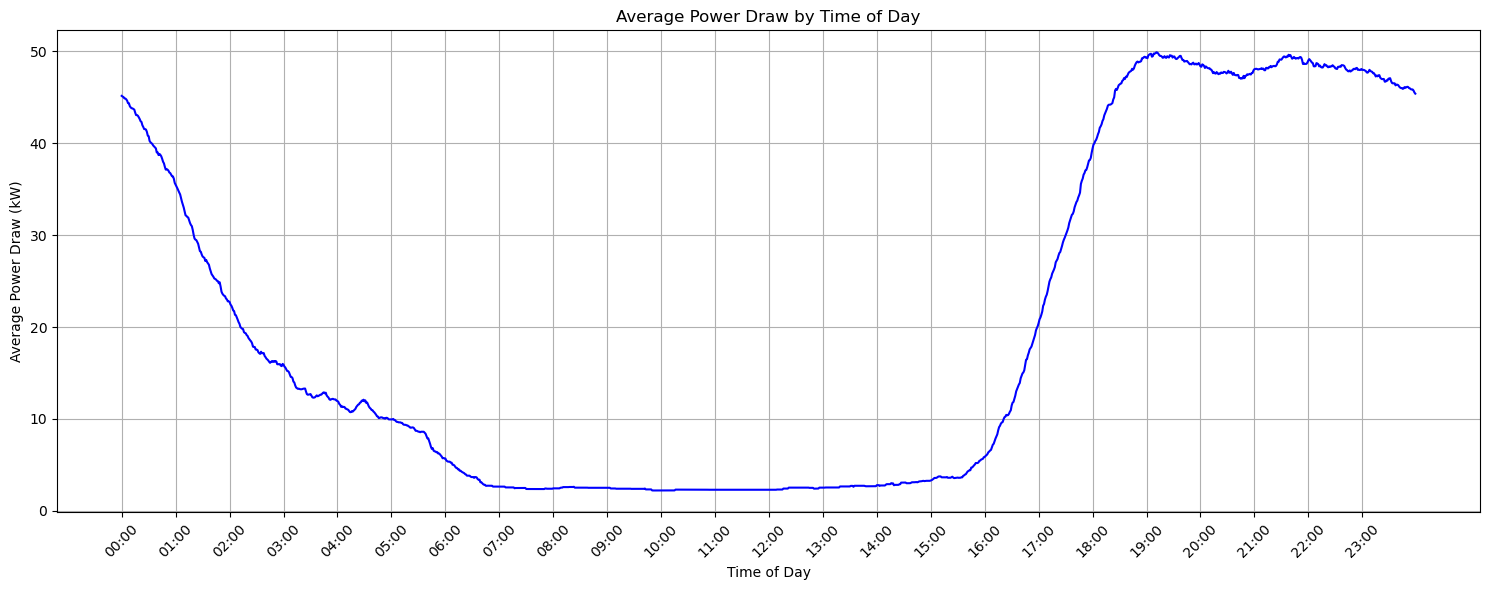

In [8]:
# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(average_power_kw, color='blue', linewidth=1.5)
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of Day")
plt.ylabel("Average Power Draw (kW)")
plt.title("Average Power Draw by Time of Day")
plt.grid(True)
plt.tight_layout()
plt.show()


In [9]:
file_path = "Data/acndata_sessions 2019_11 till 2020_5 caltech.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

In [10]:
# Define time zones
gmt_tz = pytz.timezone("GMT")  # UTC/GMT
pacific_tz = pytz.timezone("America/Los_Angeles")  # PST/PDT

# Convert relevant datetime columns
time_columns = ["connectionTime", "disconnectTime", "doneChargingTime"] 

for col in time_columns:
    df[col] = pd.to_datetime(df[col], errors="coerce")  # Convert to datetime
    df[col] = df[col].dt.tz_localize(gmt_tz, ambiguous="NaT", nonexistent="NaT")  # Assign GMT
    df[col] = df[col].dt.tz_convert(pacific_tz)  # Convert to PST/PDT



In [11]:
df.head()

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,userInputs/8/requestedDeparture,userInputs/8/userID,userInputs/9/WhPerMile,userInputs/9/kWhRequested,userInputs/9/milesRequested,userInputs/9/minutesAvailable,userInputs/9/modifiedAt,userInputs/9/paymentRequired,userInputs/9/requestedDeparture,userInputs/9/userID
0,5dd1f434f9af8b2dec17805f,39,2019-11-01 07:11:14-07:00,2019-11-01 08:27:06-07:00,2019-11-01 08:27:01-07:00,4.279,2_39_89_25_2019-11-01 14:11:13.813067,2,CA-315,2-39-89-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5dd1f434f9af8b2dec178060,39,2019-11-01 07:43:05-07:00,2019-11-01 16:36:35-07:00,2019-11-01 11:24:36-07:00,11.769,2_39_90_26_2019-11-01 14:43:04.819121,2,CA-316,2-39-90-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5dd1f434f9af8b2dec178061,39,2019-11-01 07:52:02-07:00,2019-11-01 13:54:46-07:00,2019-11-01 12:52:10-07:00,0.889,2_39_139_28_2019-11-01 14:52:02.094336,2,CA-303,2-39-139-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5dd1f434f9af8b2dec178062,39,2019-11-01 08:24:52-07:00,2019-11-01 12:19:15-07:00,2019-11-01 12:19:10-07:00,13.430,2_39_78_366_2019-11-01 15:24:51.692724,2,CA-323,2-39-78-366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5dd1f434f9af8b2dec178063,39,2019-11-01 08:59:05-07:00,2019-11-01 16:07:37-07:00,2019-11-01 12:39:17-07:00,12.001,2_39_79_383_2019-11-01 15:59:04.798455,2,CA-492,2-39-79-383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Save the updated dataset with CET timestamps
updated_file_path = "updated_charging_sessions_CET.csv"
df.to_csv(updated_file_path, index=False)

print(f"Updated file saved as: {updated_file_path}")

Updated file saved as: updated_charging_sessions_CET.csv


In [13]:
import pandas as pd
import pytz
from datetime import timedelta
import numpy as np

# Load the dataset
df = pd.read_csv("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv")

# Define the correct timezone
pacific_tz = pytz.timezone("America/Los_Angeles")

# Parse the datetime columns **WITHOUT forcing UTC**
df['connectionTime'] = pd.to_datetime(df['connectionTime'], errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], errors='coerce')

# Ensure the timestamps are correctly localized to Pacific Time
df['connectionTime'] = df['connectionTime'].dt.tz_localize(None).dt.tz_localize(pacific_tz, ambiguous='NaT', nonexistent='NaT')
df['disconnectTime'] = df['disconnectTime'].dt.tz_localize(None).dt.tz_localize(pacific_tz, ambiguous='NaT', nonexistent='NaT')

# Drop rows with missing timestamps or kWhDelivered
df = df.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered'])

# Create vectors for minute-by-minute energy usage
minutes_in_day = 24 * 60
energy_per_minute = np.zeros(minutes_in_day)
count_per_minute = np.zeros(minutes_in_day)

# Process each session
for _, row in df.iterrows():
    start = row['connectionTime']
    end = row['disconnectTime']
    energy = row['kWhDelivered']
    
    if end <= start:
        continue  # Skip invalid sessions

    # Spread energy evenly over session duration
    duration_minutes = int((end - start).total_seconds() / 60)
    if duration_minutes == 0:
        continue

    energy_per_session_minute = energy / duration_minutes

    for i in range(duration_minutes):
        minute_time = start + timedelta(minutes=i)
        minute_of_day = minute_time.hour * 60 + minute_time.minute
        energy_per_minute[minute_of_day] += energy_per_session_minute
        count_per_minute[minute_of_day] += 1

# Calculate average power draw in kW
average_power_kw = energy_per_minute  # Already in kWh per minute

print(average_power_kw[:10])  # Preview the first 10 minutes of the day


[45.14475118 45.06618053 45.01860899 44.86947504 44.85982783 44.77350451
 44.6273005  44.36034132 44.34770844 44.03188819]


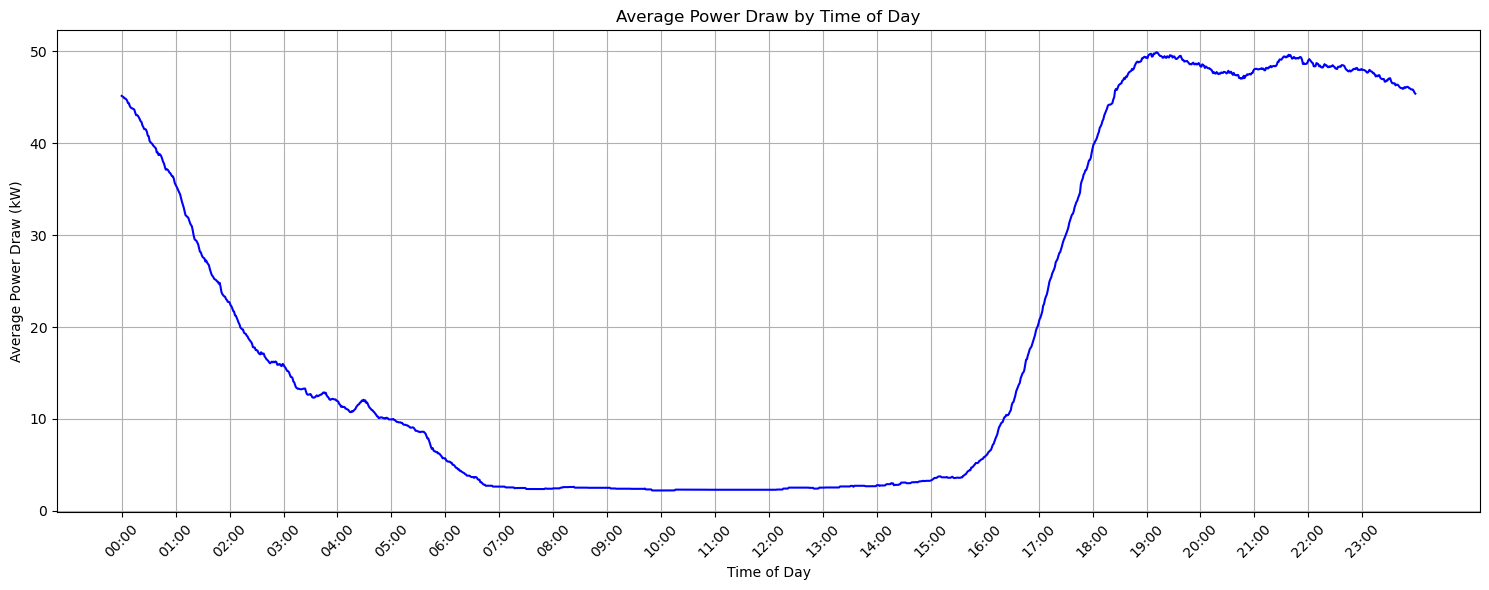

In [14]:
import matplotlib.pyplot as plt

# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(average_power_kw, color='blue', linewidth=1.5)
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of Day")
plt.ylabel("Average Power Draw (kW)")
plt.title("Average Power Draw by Time of Day")
plt.grid(True)
plt.tight_layout()
plt.show()

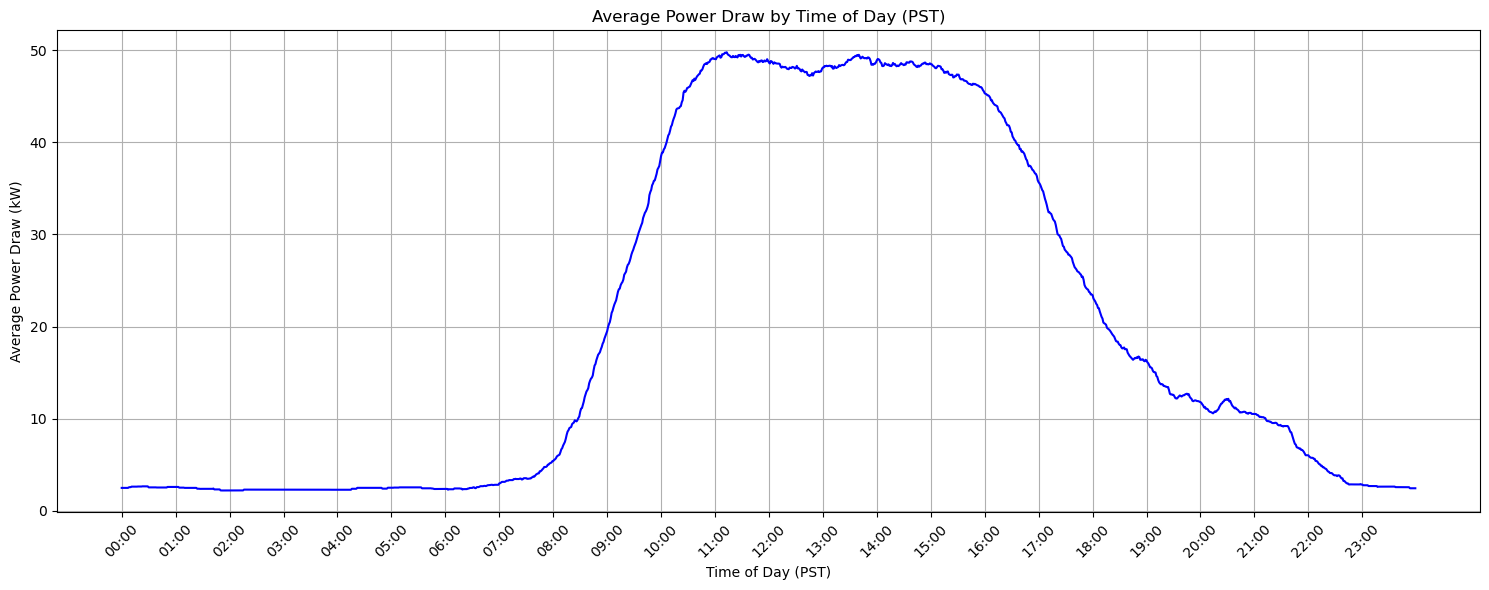

In [15]:
import pandas as pd
import pytz
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Load your CSV
df = pd.read_csv("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv")

# Define time zones
gmt_tz = pytz.timezone("GMT")
pst_tz = pytz.timezone("US/Pacific")

# Parse timestamps as UTC (since GMT is equivalent to UTC)
df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce')

# Convert from UTC (GMT) to Pacific Time, handling daylight savings
df['connectionTime'] = df['connectionTime'].dt.tz_convert(pst_tz)
df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(pst_tz)

# Drop rows with missing timestamps or kWhDelivered
df = df.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered'])

# Create a vector for total minutes in a day (PST time)
minutes_in_day = 24 * 60
energy_per_minute = np.zeros(minutes_in_day)
count_per_minute = np.zeros(minutes_in_day)
#energysessionlist

# Process each session
for _, row in df.iterrows():
    start = row['connectionTime']
    end = row['disconnectTime']
    energy = row['kWhDelivered']
    
    if end <= start:
        continue  # Skip invalid sessions

    # Spread energy evenly over session duration
    duration_minutes = int((end - start).total_seconds() / 60)
    if duration_minutes == 0:
        continue

    energy_per_session_minute = energy / duration_minutes

    for i in range(duration_minutes):
        minute_time = start + timedelta(minutes=i)
        minute_of_day = minute_time.hour * 60 + minute_time.minute
        energy_per_minute[minute_of_day] += energy_per_session_minute
        count_per_minute[minute_of_day] += 1

# Calculate average power draw in kW
average_power_kw = energy_per_minute  # Already in kWh per minute

# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot
plt.figure(figsize=(15, 6))
plt.plot(average_power_kw, color='blue', linewidth=1.5)
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of Day (PST)")
plt.ylabel("Average Power Draw (kW)")
plt.title("Average Power Draw by Time of Day (PST)")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\chris\AppData\Local\Temp\ipykernel_15412\3518754869.py:14: DtypeWarning: Columns (169,170,171,177,178,179,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


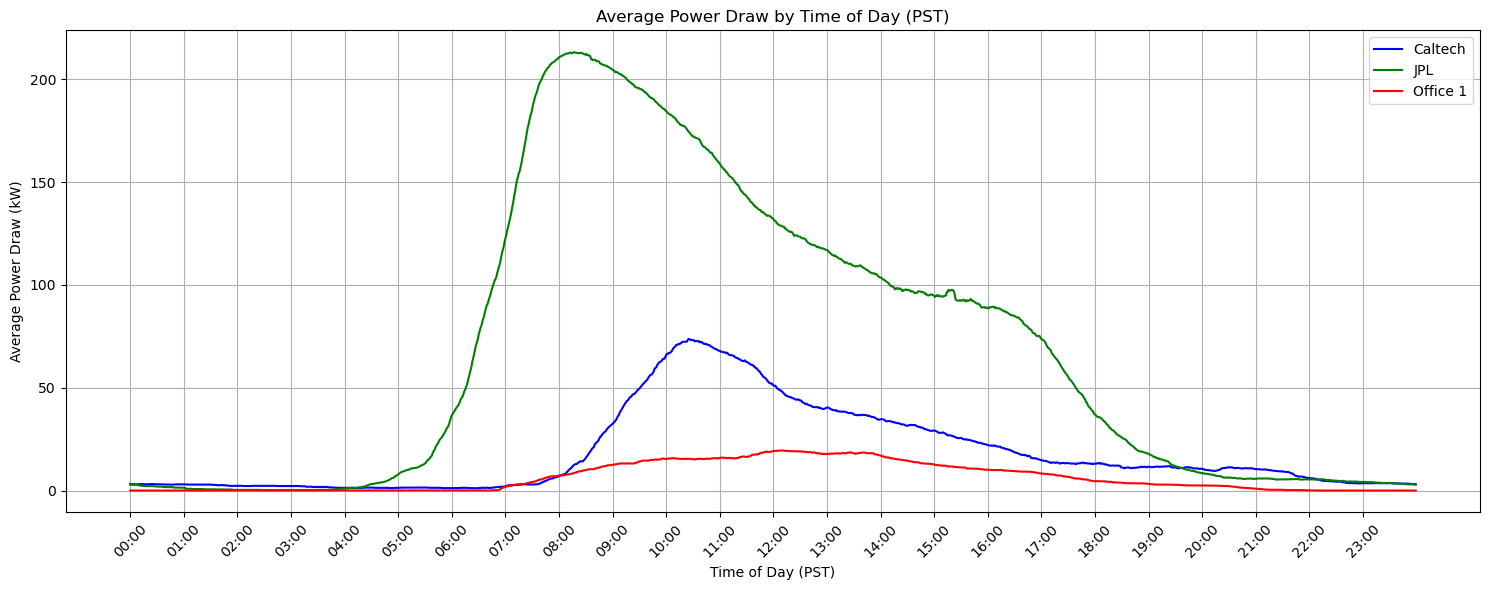

In [16]:
import pandas as pd
import pytz
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Define time zones
gmt_tz = pytz.timezone("GMT")
pst_tz = pytz.timezone("US/Pacific")

# Function to process each CSV file
def process_csv(file_path):
    # Load CSV
    df = pd.read_csv(file_path)

    # Parse timestamps as UTC (since GMT is equivalent to UTC)
    df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce')
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce')
    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True, errors='coerce')

    # Convert from UTC (GMT) to Pacific Time, handling daylight savings
    df['connectionTime'] = df['connectionTime'].dt.tz_convert(pst_tz)
    df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(pst_tz)
    df['doneChargingTime'] = df['doneChargingTime'].dt.tz_convert(pst_tz)

    # Drop rows with missing timestamps or kWhDelivered
    df = df.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered','doneChargingTime'])

    # Create vectors for energy and count per minute
    minutes_in_day = 24 * 60
    energy_per_minute = np.zeros(minutes_in_day)
    count_per_minute = np.zeros(minutes_in_day)
    energysessionlist = []

    # Process each session
    for _, row in df.iterrows():
        start = row['connectionTime']
        end = row['doneChargingTime']
        energy = row['kWhDelivered']
        
        if end <= start:
            continue  # Skip invalid sessions

        # Spread energy evenly over session duration
        duration_minutes = int((end - start).total_seconds() / 60)
        if duration_minutes == 0:
            continue

        energy_per_session_minute = energy / duration_minutes
        energysessionlist.append(energy_per_session_minute)
        for i in range(duration_minutes):
            minute_time = start + timedelta(minutes=i)
            minute_of_day = minute_time.hour * 60 + minute_time.minute
            energy_per_minute[minute_of_day] += energy_per_session_minute
            count_per_minute[minute_of_day] += 1

    return energy_per_minute

# Process the three CSV files
energy_file1 = process_csv("Data/acndata_sessions 2019_11 till 2020_5 caltech.csv")
energy_file2 = process_csv("Data/acndata_sessions 2019_11 till 2020_5 jpl.csv")  
energy_file3 = process_csv("Data/acndata_sessions 2019_11 till 2020_5 office1.csv")   

# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot the three energy curves on the same plot
plt.figure(figsize=(15, 6))
plt.plot(energy_file1, color='blue', label='Caltech', linewidth=1.5)
plt.plot(energy_file2, color='green', label='JPL', linewidth=1.5)
plt.plot(energy_file3, color='red', label='Office 1', linewidth=1.5)

# Customize the plot
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of Day (PST)")
plt.ylabel("Average Power Draw (kW)")
plt.title("Average Power Draw by Time of Day (PST)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


In [17]:
print(energy_file1)
print(len(energy_file1))
#print(len(listlistlist))

[3.13101562 3.13101562 3.13101562 ... 3.11044948 3.11044948 3.11044948]
1440


In [18]:
# Load your dataset
file_path = "Data/acndata_sessions 2019_11 till 2020_5 office1.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

# Convert time columns to datetime format
df["connectionTime"] = pd.to_datetime(df["connectionTime"], errors="coerce", utc=True)
df["doneChargingTime"] = pd.to_datetime(df["doneChargingTime"], errors="coerce", utc=True)

# Compute charging duration in hours
df["charging_duration_hrs"] = (df["doneChargingTime"] - df["connectionTime"]).dt.total_seconds() / 3600

# Compute power draw (kW)
df["power_draw_kW"] = df["kWhDelivered"] / df["charging_duration_hrs"]

# Filter out invalid values (e.g., division by zero or NaN durations)
df_valid = df[df["charging_duration_hrs"] > 0]
# Sort by connection time
df_valid = df_valid.sort_values(by="connectionTime")

# Create a list of active sessions with their end times and power draws
active_sessions = []
max_total_power = 0

# Iterate through each session
for _, row in df_valid.iterrows():
    start_time = row["connectionTime"]
    end_time = row["doneChargingTime"]
    power_draw = row["power_draw_kW"]
    
    # Remove sessions that have already ended before this one starts
    active_sessions = [(e, p) for e, p in active_sessions if e > start_time]
    
    # Add the new session
    active_sessions.append((end_time, power_draw))
    
    # Calculate total simultaneous power draw
    total_power_draw = sum(p for _, p in active_sessions)
    
    # Update max total power draw
    max_total_power = max(max_total_power, total_power_draw)

max_total_power


34.91702377572868

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pytz

# Load the data
file_path = 'Data/acndata_sessions 2019_11 till 2020_5 caltech.csv'
df = pd.read_csv(file_path)

df['date_only'] = df['connectionTime'].str.split(' ', n=3).str[1] + ' ' + df['connectionTime'].str.split(' ', n=3).str[2] + ' ' + df['connectionTime'].str.split(' ', n=3).str[3].str.split(' ', n=1).str[0]

# Define time zones
gmt_tz = pytz.timezone("GMT")
pst_tz = pytz.timezone("US/Pacific")

# Parse timestamps as UTC (since GMT is equivalent to UTC)
df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce')
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce')
df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True, errors='coerce')

# Convert from UTC (GMT) to Pacific Time, handling daylight savings
df['connectionTime'] = df['connectionTime'].dt.tz_convert(pst_tz)
df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(pst_tz)
df['doneChargingTime'] = df['doneChargingTime'].dt.tz_convert(pst_tz)

# Drop rows with missing timestamps or kWhDelivered
df = df.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered'])

df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['connectionTime'] = df['connectionTime'].dt.hour + df['connectionTime'].dt.minute / 60 + df['connectionTime'].dt.second / 3600

df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
df['disconnectTime'] = df['disconnectTime'].dt.hour + df['disconnectTime'].dt.minute / 60 + df['disconnectTime'].dt.second / 3600

df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])
df['doneChargingTime'] = df['doneChargingTime'].dt.hour + df['doneChargingTime'].dt.minute / 60 + df['doneChargingTime'].dt.second / 3600

# Drop rows with missing timestamps or kWhDelivered
df = df.dropna(subset=['connectionTime', 'disconnectTime','doneChargingTime','kWhDelivered'])
df['load'] = (df['disconnectTime'] - df['connectionTime']) / df['kWhDelivered']



df['connectionTime'] = df['connectionTime']*60
df['disconnectTime'] = df['disconnectTime']*60
df['doneChargingTime'] = df['doneChargingTime']*60

df['connectionTime'] = df['connectionTime'].astype(int)
df['disconnectTime'] = df['disconnectTime'].astype(int)
df['doneChargingTime'] = df['doneChargingTime'].astype(int)

df = df.reset_index(drop=True)

my_dict = {}
keys = list(set(df['date_only'].to_list()))
for i in range(len(keys)):
    my_dict[keys[i]] = [0] * 1440

maxlist = [0] * 1440

for i in range(0, len(df)):
    key = df.loc[i,'date_only']
    for j in range(df.loc[i,'connectionTime'], df.loc[i, 'disconnectTime']):
        my_dict[key][j] += df.loc[i,'load']

for i in range(0, 1440):
    for j in keys:
        value = my_dict[j][i]
        if value > maxlist[i]:
            maxlist[i] = value

averagelist = []
for i in range(0, 1440):
    listx = []
    for j in keys:
        listx.append(my_dict[j][i])
    filtered_listx = [x for x in listx if x != 0]
    averagelist.append(sum(listx) / len(listx))

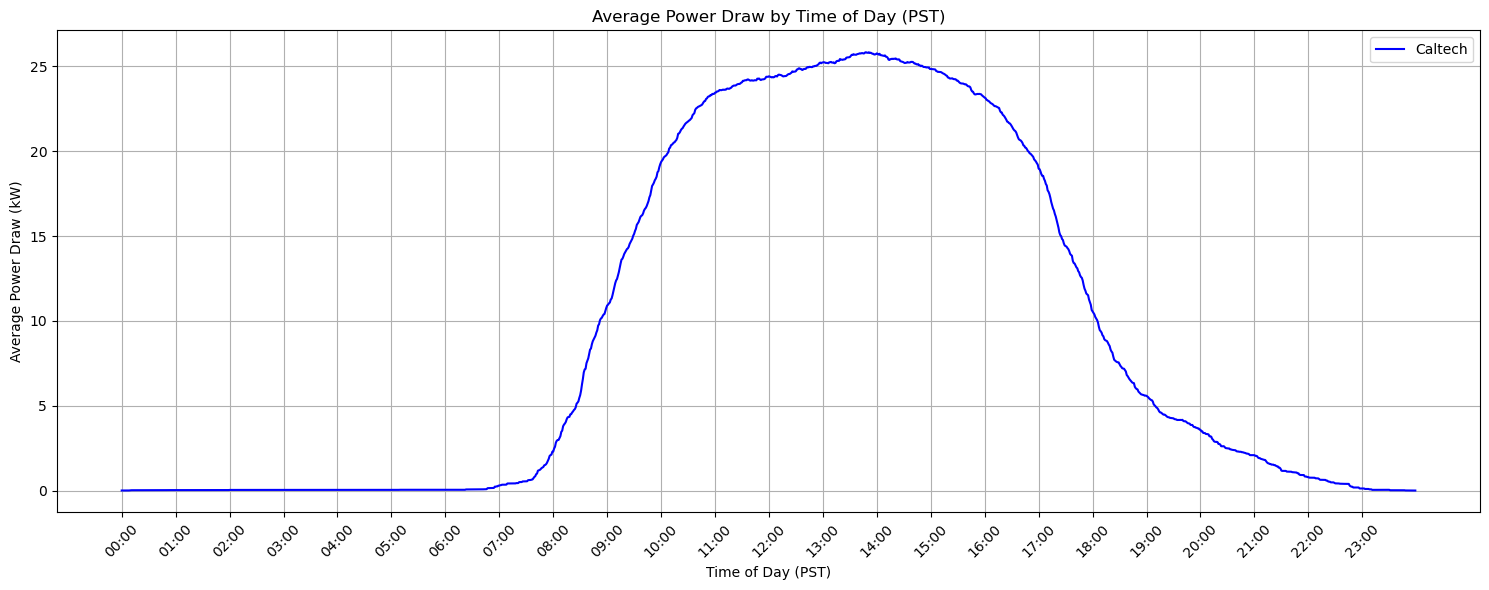

In [20]:
# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot the three energy curves on the same plot
plt.figure(figsize=(15, 6))
plt.plot(range(0,1440),averagelist, color='blue', label='Caltech', linewidth=1.5)
# plt.plot(energy_file2, color='green', label='JPL', linewidth=1.5)
# plt.plot(energy_file3, color='red', label='Office 1', linewidth=1.5)

# Customize the plot
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of Day (PST)")
plt.ylabel("Average Power Draw (kW)")
plt.title("Average Power Draw by Time of Day (PST)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

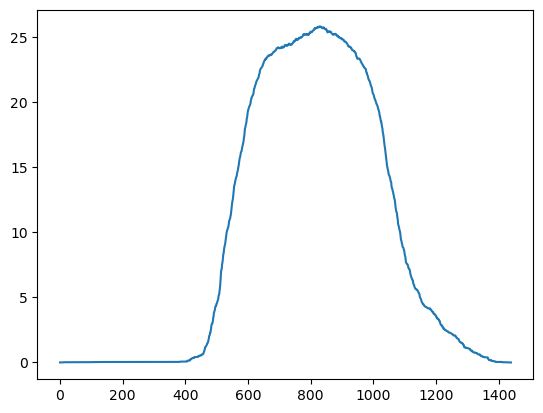

In [21]:
#plt.plot(range(0,1440),maxlist)
#print(maxlist)

plt.plot(range(0,1440),averagelist)

In [22]:
def plotter(file_path):
    df = pd.read_csv(file_path)

    df['date_only'] = df['connectionTime'].str.split(' ', n=3).str[1] + ' ' + df['connectionTime'].str.split(' ', n=3).str[2] + ' ' + df['connectionTime'].str.split(' ', n=3).str[3].str.split(' ', n=1).str[0]

    # Define time zones
    gmt_tz = pytz.timezone("GMT")
    pst_tz = pytz.timezone("US/Pacific")

    # Parse timestamps as UTC (since GMT is equivalent to UTC)
    df['connectionTime'] = pd.to_datetime(df['connectionTime'], utc=True, errors='coerce')
    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'], utc=True, errors='coerce')
    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'], utc=True, errors='coerce')

    # Convert from UTC (GMT) to Pacific Time, handling daylight savings
    df['connectionTime'] = df['connectionTime'].dt.tz_convert(pst_tz)
    df['disconnectTime'] = df['disconnectTime'].dt.tz_convert(pst_tz)
    df['doneChargingTime'] = df['doneChargingTime'].dt.tz_convert(pst_tz)

    # Drop rows with missing timestamps or kWhDelivered
    df = df.dropna(subset=['connectionTime', 'disconnectTime', 'kWhDelivered'])

    df['connectionTime'] = pd.to_datetime(df['connectionTime'])
    df['connectionTime'] = df['connectionTime'].dt.hour + df['connectionTime'].dt.minute / 60 + df['connectionTime'].dt.second / 3600

    df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])
    df['disconnectTime'] = df['disconnectTime'].dt.hour + df['disconnectTime'].dt.minute / 60 + df['disconnectTime'].dt.second / 3600

    df['doneChargingTime'] = pd.to_datetime(df['doneChargingTime'])
    df['doneChargingTime'] = df['doneChargingTime'].dt.hour + df['doneChargingTime'].dt.minute / 60 + df['doneChargingTime'].dt.second / 3600

    # Drop rows with missing timestamps or kWhDelivered
    df = df.dropna(subset=['connectionTime', 'disconnectTime','doneChargingTime','kWhDelivered'])
    df['load'] = (df['doneChargingTime'] - df['connectionTime']) / df['kWhDelivered']

    df['connectionTime'] = df['connectionTime']*60
    df['disconnectTime'] = df['disconnectTime']*60
    df['doneChargingTime'] = df['doneChargingTime']*60

    df['connectionTime'] = df['connectionTime'].astype(int)
    df['disconnectTime'] = df['disconnectTime'].astype(int)
    df['doneChargingTime'] = df['doneChargingTime'].astype(int)

    df = df.reset_index(drop=True)

    my_dict = {}
    keys = list(set(df['date_only'].to_list()))
    for i in range(len(keys)):
        my_dict[keys[i]] = [0] * 1440

    maxlist = [0] * 1440

    for i in range(0, len(df)):
        key = df.loc[i,'date_only']
        for j in range(df.loc[i,'connectionTime'], df.loc[i, 'doneChargingTime']):
            my_dict[key][j] += df.loc[i,'load']

    for i in range(0, 1440):
        for j in keys:
            value = my_dict[j][i]
            if value > maxlist[i]:
                maxlist[i] = value

    averagelist = []
    for i in range(0, 1440):
        listx = []
        for j in keys:
            listx.append(my_dict[j][i])
        filtered_listx = [x for x in listx if x != 0]
        if len(filtered_listx) == 0:
            averagelist.append(0)
        else:
            averagelist.append(sum(filtered_listx) / len(filtered_listx))
        #print(listx)
        #print(filtered_listx)
    return averagelist, maxlist

In [23]:
average, max = plotter('Data/acndata_sessions 2019_11 till 2020_5 caltech.csv')

C:\Users\chris\AppData\Local\Temp\ipykernel_15412\1962292617.py:2: DtypeWarning: Columns (169,170,171,177,178,179,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


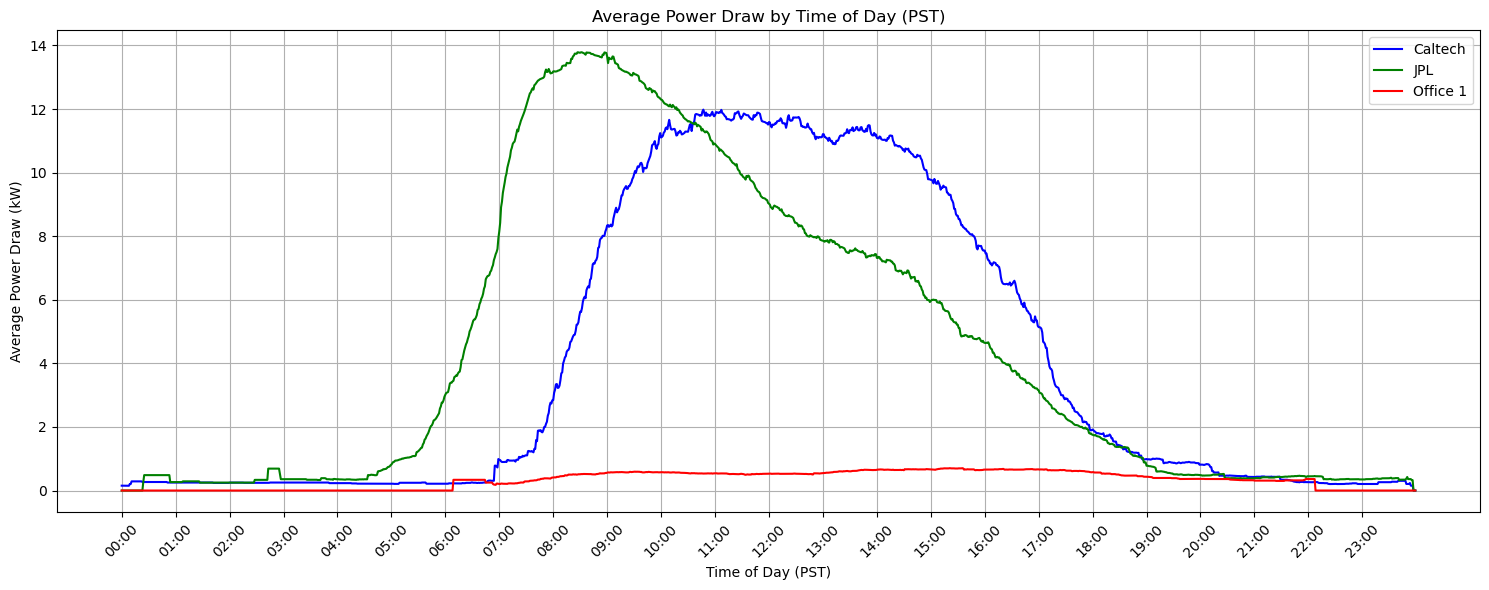

In [24]:
# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot the three energy curves on the same plot
plt.figure(figsize=(15, 6))
plt.plot(range(0,1440),plotter('Data/acndata_sessions 2019_11 till 2020_5 caltech.csv')[0], color='blue', label='Caltech', linewidth=1.5)
plt.plot(range(0,1440),plotter('Data/acndata_sessions 2019_11 till 2020_5 jpl.csv')[0], color='green', label='JPL', linewidth=1.5)
plt.plot(range(0,1440),plotter('Data/acndata_sessions 2019_11 till 2020_5 office1.csv')[0], color='red', label='Office 1', linewidth=1.5)

# Customize the plot
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of Day (PST)")
plt.ylabel("Average Power Draw (kW)")
plt.title("Average Power Draw by Time of Day (PST)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

C:\Users\chris\AppData\Local\Temp\ipykernel_15412\1962292617.py:2: DtypeWarning: Columns (169,170,171,177,178,179,185,186,187) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


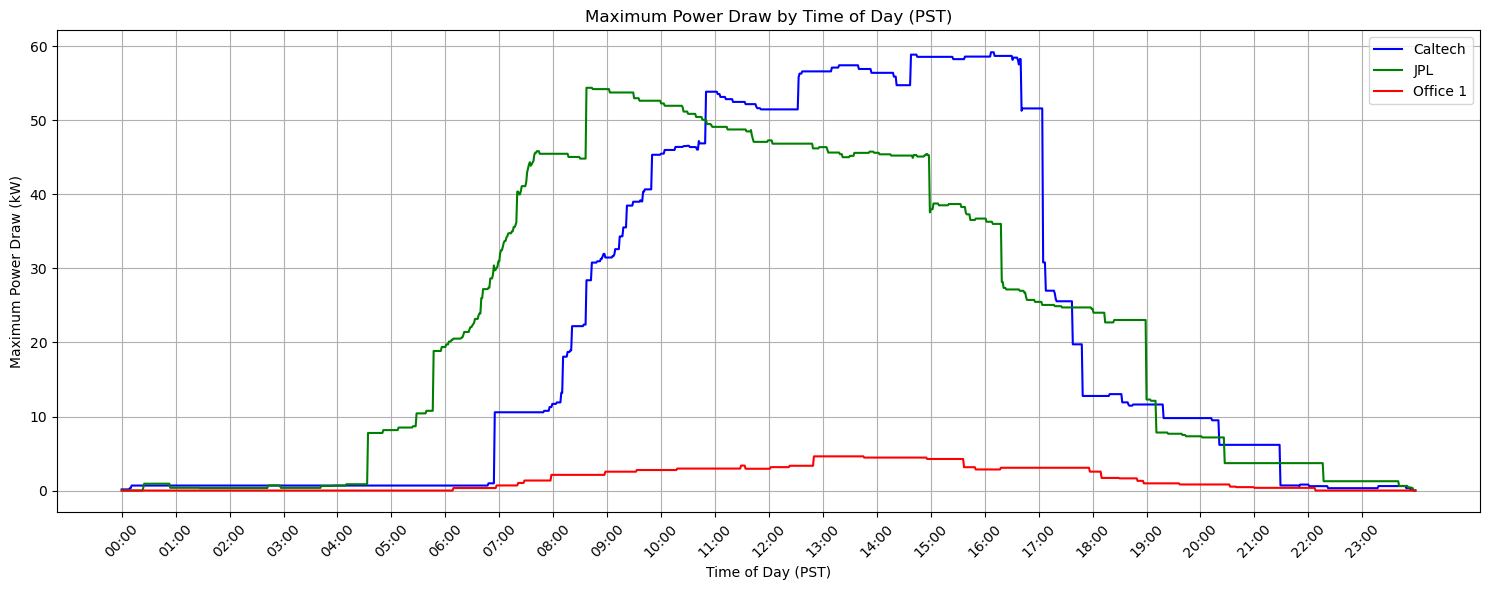

In [25]:
# Generate time labels for x-axis (every hour)
time_labels = [f"{h:02d}:00" for h in range(24)]
time_ticks = [h * 60 for h in range(24)]

# Plot the three energy curves on the same plot
plt.figure(figsize=(15, 6))
plt.plot(range(0,1440),plotter('Data/acndata_sessions 2019_11 till 2020_5 caltech.csv')[1], color='blue', label='Caltech', linewidth=1.5)
plt.plot(range(0,1440),plotter('Data/acndata_sessions 2019_11 till 2020_5 jpl.csv')[1], color='green', label='JPL', linewidth=1.5)
plt.plot(range(0,1440),plotter('Data/acndata_sessions 2019_11 till 2020_5 office1.csv')[1], color='red', label='Office 1', linewidth=1.5)

# Customize the plot
plt.xticks(time_ticks, time_labels, rotation=45)
plt.xlabel("Time of Day (PST)")
plt.ylabel("Maximum Power Draw (kW)")
plt.title("Maximum Power Draw by Time of Day (PST)")
plt.grid(True)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

In [26]:
print(energy_file1)
print(type(energy_file1))

[3.13101562 3.13101562 3.13101562 ... 3.11044948 3.11044948 3.11044948]
<class 'numpy.ndarray'>


In [27]:
print(average)

[np.float64(0.15287818247607612), np.float64(0.15287818247607612), np.float64(0.15287818247607612), np.float64(0.15287818247607612), np.float64(0.15287818247607612), np.float64(0.15287818247607612), np.float64(0.15287818247607612), np.float64(0.15287818247607612), np.float64(0.15047892972431645), np.float64(0.2047478454031623), np.float64(0.2047478454031623), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.28803295297711706), np.float64(0.26826097244347274), np.float64(0.26826097244347274), np.float64(0.26826097244347274), np.float64(0.26826097244347274), np.float64(0.26826097244347274), np.float64(0.26826097244347274), np.float64(0.26826097244347274), np.float64(

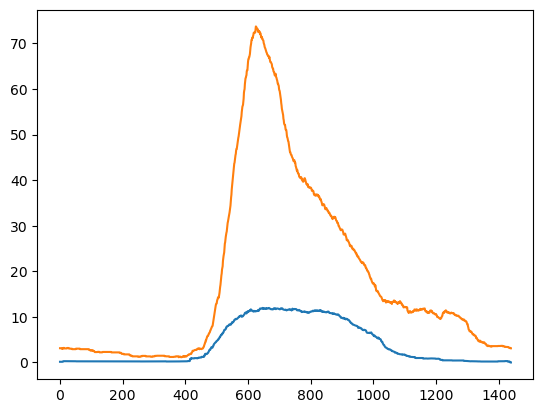

In [28]:
plt.plot(range(0,1440),average)
plt.plot(range(0,1440), energy_file1)

In [29]:
print(listlistlist)

NameError: name 'listlistlist' is not defined

In [30]:
display(df)

,_id,clusterID,connectionTime,disconnectTime,doneChargingTime,kWhDelivered,sessionID,siteID,spaceID,stationID,...,userInputs/9/WhPerMile,userInputs/9/kWhRequested,userInputs/9/milesRequested,userInputs/9/minutesAvailable,userInputs/9/modifiedAt,userInputs/9/paymentRequired,userInputs/9/requestedDeparture,userInputs/9/userID,date_only,load
0,5dd1f434f9af8b2dec17805f,39,431,507,507,4.279,2_39_89_25_2019-11-01 14:11:13.813067,2,CA-315,2-39-89-25,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 Nov 2019,0.295500
1,5dd1f434f9af8b2dec178060,39,463,996,684,11.769,2_39_90_26_2019-11-01 14:43:04.819121,2,CA-316,2-39-90-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 Nov 2019,0.755516
2,5dd1f434f9af8b2dec178061,39,472,834,772,0.889,2_39_139_28_2019-11-01 14:52:02.094336,2,CA-303,2-39-139-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 Nov 2019,6.800400
3,5dd1f434f9af8b2dec178062,39,504,739,739,13.430,2_39_78_366_2019-11-01 15:24:51.692724,2,CA-323,2-39-78-366,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 Nov 2019,0.290870
4,5dd1f434f9af8b2dec178063,39,539,967,759,12.001,2_39_79_383_2019-11-01 15:59:04.798455,2,CA-492,2-39-79-383,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,01 Nov 2019,0.595136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,5ed1a90bf9af8b32e9f098e3,39,610,741,741,14.939,2_39_127_19_2020-05-13 17:10:07.807386,2,CA-309,2-39-127-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13 May 2020,0.146615
3226,5ed59d8bf9af8b757dd700ba,39,611,1211,1069,48.878,2_39_131_30_2020-05-16 17:11:22.543804,2,CA-305,2-39-131-30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16 May 2020,0.204511
3227,5ee2cc8df9af8b67c338cd47,39,786,937,938,0.820,2_39_139_28_2020-05-26 20:06:06.399729,2,CA-303,2-39-139-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26 May 2020,3.070461
3228,5ee2cc8df9af8b67c338cd48,39,937,947,947,0.544,2_39_139_28_2020-05-26 22:37:29.854698,2,CA-303,2-39-139-28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26 May 2020,0.305862
